# Progetto IDS
### Nicolò Calandra - Andrea Di Blasi

## Obiettivo Analitico
L'obiettivo primario di questa analisi è investigare come la **posizione finale in gara** di un pilota sia influenzata da una combinazione di fattori, tra cui la **posizione ottenuta in qualifica** e la **forma fisica del pilota** (rappresentata dalla classifica generale dopo l'ultima gara). Particolare attenzione è data a come queste correlazioni varino in base alla **tipologia di circuito**, che abbiamo classificato in tre categorie distinte:
*   **Circuito Tecnico:** Caratterizzato da numerose curve, dove l'abilità e la tecnica del pilota tendono a prevalere sulla pura potenza del veicolo.
*   **Circuito ad Alta Velocità:** Dominato da lunghi rettilinei, dove la performance del motore e l'aerodinamica del veicolo giocano un ruolo più critico rispetto alla destrezza del pilota nel determinare il risultato.
*   **Circuito Misto:** Un tracciato che bilancia le caratteristiche dei due tipi precedenti.

## Caratteristiche del Dataset
Abbiamo utilizzato il dataset **F1DB**, che contiene dati sulla Formula 1 dal 1950 al 2024. Le tabelle principali utilizzate sono:
*   **`circuits`**: Contiene informazioni dettagliate su tutte le piste. Questa tabella è stata da noi **arricchita manualmente** con la classificazione del "tipo di circuito" (Tecnico, Alta Velocità, Misto) basata sulla nostra conoscenza dei tracciati.
*   **`results`** (o `race_results`): Fornisce i risultati dettagliati di ogni gara.
*   **`races`**: Contiene informazioni generali su ciascun evento di gara.

In preparazione alla fase di modellazione predittiva (un modello di **regressione logistica**), abbiamo integrato questi dati con la tabella **`driver_standings`**. Questo ci permette di includere come feature la **classifica generale del pilota prima di ogni rispettivo gran premio**, un indicatore utile della sua performance e costanza nel corso della stagione.

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
import sklearn.metrics as metrics

## Caricamento dati

In [3]:
circuits = pd.read_csv("f1db-csv/f1db-circuits.csv")
races = pd.read_csv("f1db-csv/f1db-races.csv")
results = pd.read_csv("f1db-csv/f1db-races-race-results.csv", low_memory=False)

driver_standings = pd.read_csv("f1db-csv/f1db-races-driver-standings.csv")

## Visualizzazione dati
Visualizziamo i dataset caricati per capire meglio le informazioni contenute.
Utilizziamo due metodi diversi:
*   `head` per vedere le prime righe di ogni tabella e comprendere quali dati sono contenuti,

*   `info` per vedere le informazioni relative a ogni colonna e anche i nomi delle colonne in maniera più ordinata e chiara.

In [4]:
circuits.head()

,id,name,fullName,previousNames,type,direction,placeName,countryId,latitude,longitude,length,turns,totalRacesHeld,circuitType
0,adelaide,Adelaide,Adelaide Street Circuit,NaN,STREET,CLOCKWISE,Adelaide,australia,-34.927222,138.617222,3.780,16,11,Tecnico
1,aida,Aida,Okayama International Circuit,TI Circuit Aida,RACE,CLOCKWISE,Aida,japan,34.915000,134.221111,3.703,13,2,Tecnico
2,ain-diab,Ain-Diab,Ain-Diab Circuit,NaN,ROAD,CLOCKWISE,Casablanca,morocco,33.578611,-7.687500,7.618,18,1,Misto
3,aintree,Aintree,Aintree Motor Racing Circuit,NaN,ROAD,CLOCKWISE,Aintree,united-kingdom,53.476944,-2.940556,4.828,8,5,Misto
4,anderstorp,Anderstorp Raceway,Anderstorp Raceway,Scandinavian Raceway,RACE,CLOCKWISE,Anderstorp,sweden,57.264167,13.601389,4.031,8,6,Tecnico


In [5]:
circuits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              77 non-null     object 
 1   name            77 non-null     object 
 2   fullName        77 non-null     object 
 3   previousNames   15 non-null     object 
 4   type            77 non-null     object 
 5   direction       77 non-null     object 
 6   placeName       77 non-null     object 
 7   countryId       77 non-null     object 
 8   latitude        77 non-null     float64
 9   longitude       77 non-null     float64
 10  length          77 non-null     float64
 11  turns           77 non-null     int64  
 12  totalRacesHeld  77 non-null     int64  
 13  circuitType     77 non-null     object 
dtypes: float64(3), int64(2), object(9)
memory usage: 8.5+ KB


In [6]:
races.head()

,id,year,round,date,time,grandPrixId,officialName,qualifyingFormat,sprintQualifyingFormat,circuitId,...,qualifying2Date,qualifying2Time,qualifyingDate,qualifyingTime,sprintQualifyingDate,sprintQualifyingTime,sprintRaceDate,sprintRaceTime,warmingUpDate,warmingUpTime
0,1,1950,1,1950-05-13,NaN,great-britain,1950 RAC British Grand Prix,TWO_SESSION,NaN,silverstone,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1950,2,1950-05-21,NaN,monaco,Grand Prix de Monaco 1950,TWO_SESSION,NaN,monaco,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1950,3,1950-05-30,NaN,indianapolis,1950 Indianapolis 500,FOUR_LAPS,NaN,indianapolis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1950,4,1950-06-04,NaN,switzerland,Grosser Preis der Schweiz 1950,TWO_SESSION,NaN,bremgarten,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1950,5,1950-06-18,NaN,belgium,1950 Belgian Grand Prix,TWO_SESSION,NaN,spa-francorchamps,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               1149 non-null   int64  
 1   year                             1149 non-null   int64  
 2   round                            1149 non-null   int64  
 3   date                             1149 non-null   object 
 4   time                             48 non-null     object 
 5   grandPrixId                      1149 non-null   object 
 6   officialName                     1149 non-null   object 
 7   qualifyingFormat                 1149 non-null   object 
 8   sprintQualifyingFormat           18 non-null     object 
 9   circuitId                        1149 non-null   object 
 10  circuitType                      1149 non-null   object 
 11  direction                        1149 non-null   object 
 12  courseLength        

In [8]:
results.head()

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,polePosition,qualificationPositionNumber,qualificationPositionText,gridPositionNumber,gridPositionText,positionsGained,pitStops,fastestLap,driverOfTheDay,grandSlam
0,1,1950,1,1,1.0,1,2,nino-farina,alfa-romeo,alfa-romeo,...,True,1.0,1,1.0,1,0.0,NaN,True,NaN,False
1,1,1950,1,2,2.0,2,3,luigi-fagioli,alfa-romeo,alfa-romeo,...,False,2.0,2,2.0,2,0.0,NaN,False,NaN,False
2,1,1950,1,3,3.0,3,4,reg-parnell,alfa-romeo,alfa-romeo,...,False,4.0,4,4.0,4,1.0,NaN,False,NaN,False
3,1,1950,1,4,4.0,4,14,yves-giraud-cabantous,talbot-lago,talbot-lago,...,False,6.0,6,6.0,6,2.0,NaN,False,NaN,False
4,1,1950,1,5,5.0,5,15,louis-rosier,talbot-lago,talbot-lago,...,False,9.0,9,9.0,9,4.0,NaN,False,NaN,False


In [9]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26911 entries, 0 to 26910
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   raceId                       26911 non-null  int64  
 1   year                         26911 non-null  int64  
 2   round                        26911 non-null  int64  
 3   positionDisplayOrder         26911 non-null  int64  
 4   positionNumber               16096 non-null  float64
 5   positionText                 26911 non-null  object 
 6   driverNumber                 26911 non-null  int64  
 7   driverId                     26911 non-null  object 
 8   constructorId                26911 non-null  object 
 9   engineManufacturerId         26911 non-null  object 
 10  tyreManufacturerId           26911 non-null  object 
 11  sharedCar                    26911 non-null  bool   
 12  laps                         24991 non-null  float64
 13  time            

## Pulizia Dati

A questo punto dobbiamo creare un dataframe che contenga solamente le informazioni necessarie per la parte di visualizzazione, ovvero:
* la posizione di partenza
* la posizione finale
* il tipo di circuito
* una categoria in base alla posizione finale:
    * Podio [1-3]
    * Punti [4-10] (i primi 10 piloti prendono punti)
    * No punti [11-22]

Inoltre dobbiamo filtrare le gare per anno prendendo solo quelle dopo il 2000. In questo modo, come vedremo dopo, otteniamo una maggiore precisione del modello di regressione logistica. Infatti, gare troppo vecchie hanno molti dati mancanti e molti più incidenti, influenzando negativamente la precisione del modello.

In [10]:
# Possiamo anche filtrare i dati per mantenere solo quelli più recenti
results_old = results[results['year'] < 2000]


results = results[results['year'] >= 2000]
results_dnf = results

# Facciamo un merge tra i risultati e le gare
races.rename(columns={'id': 'raceId'}, inplace=True)
df = pd.merge(results, races, on='raceId', how='left', validate='m:1')  

# Facciamo un merge tra i risultati e i circuiti
circuits.rename(columns={'id': 'circuitId'}, inplace=True)
df = pd.merge(df, circuits, on='circuitId', how='left', validate='m:1')

# Selezioniamo solo le colonne che ci servono
df = df[['gridPositionNumber', 'positionNumber', 'circuitType_y']]

df.rename(columns={'circuitType_y': 'tipo_circuito'}, inplace=True)
df.rename(columns={'gridPositionNumber': 'posizione_partenza'}, inplace=True)
df.rename(columns={'positionNumber': 'posizione_finale'}, inplace=True)

# Selezioniamo solo le gare in cui il pilota parte da una delle prime due file
df = df[(df['posizione_partenza'] <= 4) & (df['posizione_partenza'] > 0)]
df = df[df['posizione_finale'] < 23]

# Creiamo una categoria per la posizione finale
df['punti'] = df['posizione_finale'].apply(lambda x: 'Non arrivato' if x == 0 else 'Podio' if x <= 3 else 'Punti' if x <= 10 else 'No punti')

# Eliminiamo le righe che contengono informazioni nulle
df = df.dropna()


df.head()


,posizione_partenza,posizione_finale,tipo_circuito,punti
0,3.0,1.0,Tecnico,Podio
1,4.0,2.0,Tecnico,Podio
22,3.0,1.0,Misto,Podio
44,2.0,1.0,Tecnico,Podio
45,1.0,2.0,Tecnico,Podio


## Visualizzazione Dati

Dopo aver preparato i nostri dati (contenuti nel dataframe `df`), uno degli aspetti più interessanti da esplorare è come la posizione di partenza influenzi il piazzamento finale, e come questa relazione cambi a seconda del tipo di circuito.

### Impatto della Partenza dalla Top 4 sulla Posizione Finale per Tipo di Circuito

Per investigare questo, presentiamo di seguito un **istogramma**. In questo modo possiamo mostrare la **distribuzione delle posizioni finali** ottenute dai piloti che hanno iniziato la gara partendo dalle **prime quattro posizioni della griglia** (cioè, le prime due file).

La visualizzazione è ulteriormente **divisa per le tre tipologie di circuito** che abbiamo identificato: "Tecnico", "Alta Velocità" e "Misto".

In dettaglio, per ciascuna categoria di circuito, il grafico illustra:
*   Sull'**asse orizzontale (X)**: Le diverse posizioni finali ottenute in gara (es. 1°, 2°, 3°, ...).
*   Sull'**asse verticale (Y)**: Il **numero di volte (frequenza)** in cui un pilota, partito dalle prime quattro posizioni, ha concluso la gara in quella specifica posizione finale.

L'obiettivo di questa visualizzazione è di evidenziare se i piloti che partono davanti riescono a mantenere o migliorare la loro posizione più facilmente su certi tipi di tracciati rispetto ad altri, offrendo così una prima indicazione su dove la posizione di partenza è un vantaggio più critico.

## Istogramma


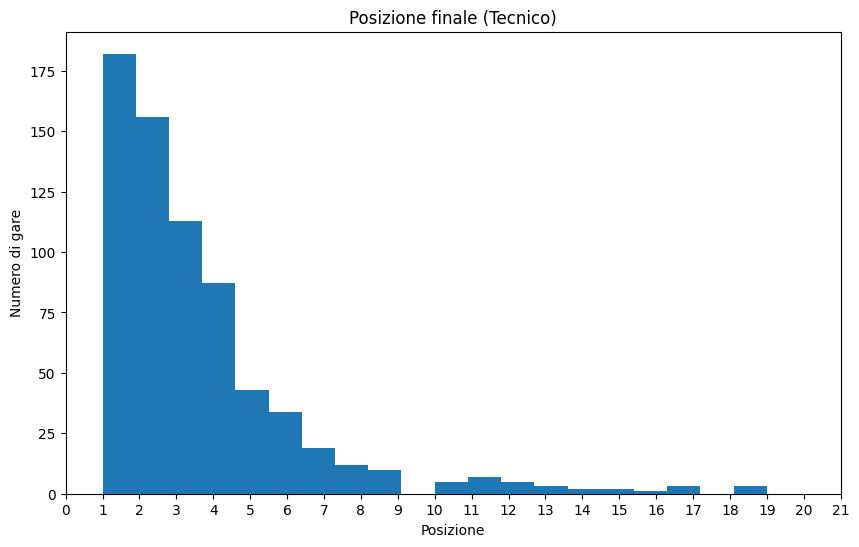

In [11]:
position_technical = df[df["tipo_circuito"] == "Tecnico"]
plt.figure(figsize=(10, 6))
plt.hist(position_technical["posizione_finale"].astype(int), bins=20)
plt.xlabel("Posizione") 
plt.ylabel("Numero di gare")
plt.title("Posizione finale (Tecnico)")
plt.xticks(range(0, 22))
plt.show()


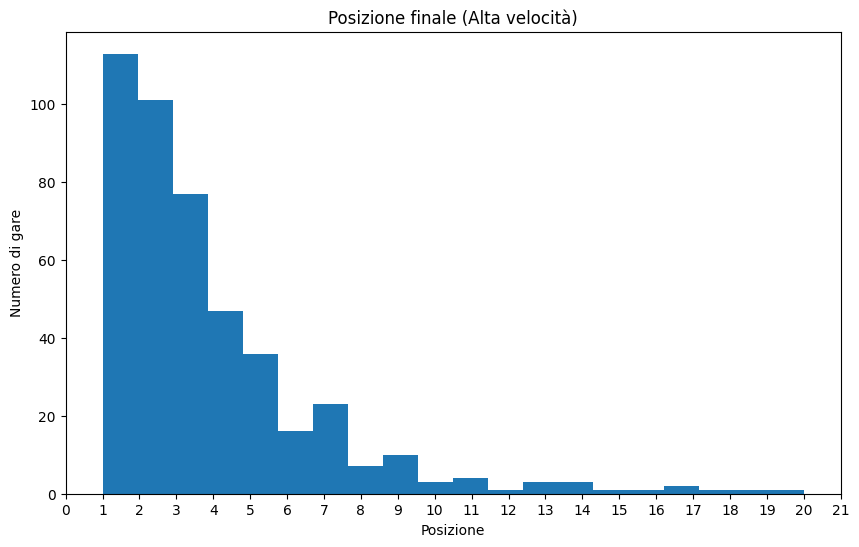

In [12]:
position_highspeed = df[df["tipo_circuito"] == "Alta velocità"]
plt.figure(figsize=(10, 6))
plt.hist(position_highspeed["posizione_finale"].astype(int), bins=20)
plt.xlabel("Posizione") 
plt.ylabel("Numero di gare")
plt.title("Posizione finale (Alta velocità)")
plt.xticks(range(0, 22))
plt.show()

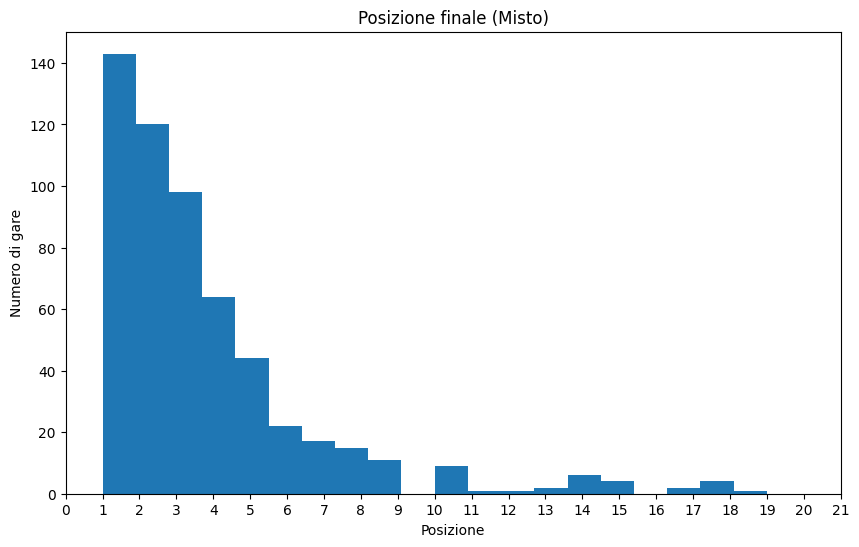

In [13]:
position_misto = df[df["tipo_circuito"] == "Misto"]
plt.figure(figsize=(10, 6))
plt.hist(position_misto["posizione_finale"].astype(int), bins=20)
plt.xlabel("Posizione") 
plt.ylabel("Numero di gare")
plt.xticks(range(0, 22))
plt.title("Posizione finale (Misto)")

plt.show()

### Calcolo della posizione media per ogni tipo di circuito
Ora che abbiamo visualizzato le posizioni finali tramite degli istogrammi, possiamo calcolare la posizione media per ogni tipo di circuito

In [14]:
# Calcoliamo la media per ogni tipo di circuito
tipo_circuito = ["Tecnico", "Alta velocità", "Misto"]
media = {}

for i in range(0, len(tipo_circuito)):
    print("----" + tipo_circuito[i] + "----")
    df_i = df[df['tipo_circuito'] == tipo_circuito[i]]
    media[i] = df_i['posizione_finale'].mean()
    print("Posizione media: " + str(media[i]) + "\n")

----Tecnico----
Posizione media: 3.3871906841339157

----Alta velocità----
Posizione media: 3.5609756097560976

----Misto----
Posizione media: 3.601063829787234



### Osservazione

Valutando le prestazioni dei piloti che sono partiti nelle prime quattro posizioni (P1, P2, P3, P4), osserviamo le seguenti posizioni medie finali, suddivise per tipologia di circuito:

*   **Circuiti Tecnici:**
    *   Posizione media finale: **3.39**
*   **Circuiti ad Alta Velocità:**
    *   Posizione media finale: **3.56**
*   **Circuiti Misti:**
    *   Posizione media finale: **3.60**

I dati suggeriscono che i piloti partiti dalle prime tre posizioni tendono a ottenere, in media, piazzamenti leggermente migliori sui circuiti *Tecnici* (media ~3.39) rispetto a quelli ad *Alta Velocità* (media ~3.56) o *Misti* (media ~3.60). 

## Box Plot
Adesso visualizziamo i dati tramite dei box plot, che ci permettono di studiare:
*   La **mediana** (la linea centrale del box), che rappresenta il valore centrale della distribuzione.
*   Il **range interquartile (IQR)** (l'altezza del box), che contiene il 50% centrale dei dati (dal 25° al 75° percentile).
*   I **"baffi" (whiskers)**, che tipicamente si estendono fino a 1.5 volte l'IQR dai bordi del box, coprendo la maggior parte dei dati.
*   Eventuali **outlier**, mostrati come punti individuali oltre i baffi.

Creeremo un box plot separato per ciascuna delle tre categorie di circuito ("Tecnico", "Alta Velocità", "Misto"). Questo ci permetterà di confrontare la mediana tra i vari circuiti e confrontarla con la media per vedere se ci fosse un numero significativo di outliers.

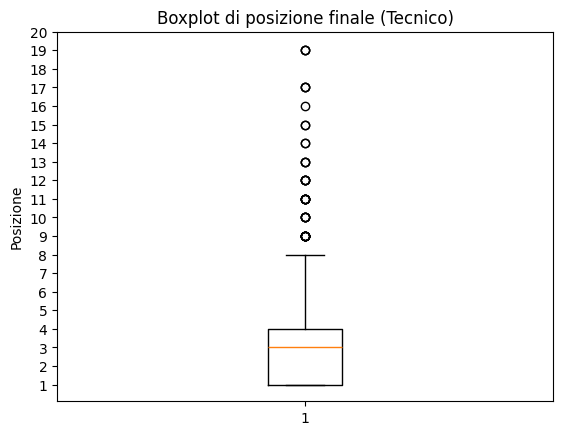

In [15]:
plt.boxplot(position_technical["posizione_finale"].astype(int))
plt.yticks(range(1, 21))
plt.ylabel("Posizione")
plt.title("Boxplot di posizione finale (Tecnico)")
plt.show()

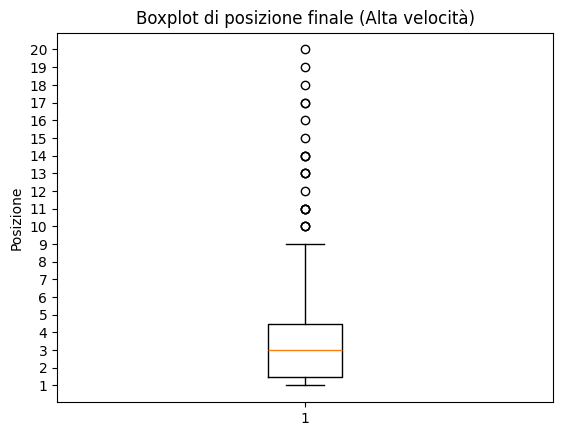

In [16]:
plt.boxplot(position_highspeed["posizione_finale"].astype(int))
plt.yticks(range(1, 21))
plt.ylabel("Posizione")
plt.title("Boxplot di posizione finale (Alta velocità)")
plt.show()

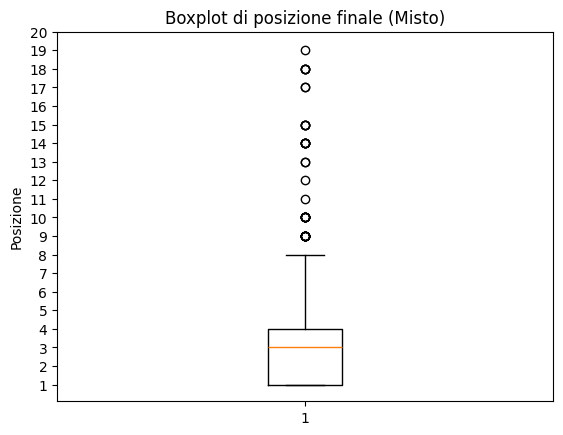

In [17]:
plt.boxplot(position_misto["posizione_finale"].astype(int))
plt.yticks(range(1, 21))
plt.ylabel("Posizione")
plt.title("Boxplot di posizione finale (Misto)")
plt.show()

### Calcolo della mediana per tipo di circuito

Ora che abbiamo visualizzato le posizioni finali tramite dei box plot, possiamo calcolare la mediana per ogni tipo di circuito

In [18]:
# Calcoliamo la mediana per ogni tipo di circuito
mediana = {}

for i in range(0, len(tipo_circuito)):
    print("----" + tipo_circuito[i] + "----")
    df_i = df[df['tipo_circuito'] == tipo_circuito[i]]
    mediana[i] = df_i['posizione_finale'].median()
    print("Posizione media: " + str(mediana[i]) + "\n")

----Tecnico----
Posizione media: 3.0

----Alta velocità----
Posizione media: 3.0

----Misto----
Posizione media: 3.0



### Confronto Media-Mediana

Per valutare la presenza e l'impatto di valori anomali (outlier) sulla distribuzione di **Posizione finale** per ciascuna tipologia di circuito, abbiamo confrontato la media e la mediana. La media, essendo sensibile ai valori estremi, tende a discostarsi dalla mediana (misura più robusta della tendenza centrale) in presenza di distribuzioni asimmetriche causate da outlier.

**Statistiche di Posizione finale per Tipologia di Circuito:**

| Tipologia Circuito | Media di Posizione finale | Mediana di Posizione finale | Differenza (Media - Mediana) |
|--------------------|-----------------------------|-------------------------------|------------------------------|
| Tecnico            | 3.387                       | 3.0                           | 0.387                        |
| Alta Velocità      | 3.561                       | 3.0                           | 0.561                        |
| Misto              | 3.601                       | 3.0                           | 0.601                        |

**Interpretazione:**

In tutte e tre le categorie di circuito, osserviamo che la **media di Posizione finale è superiore alla sua mediana**. Questo indica una **distribuzione asimmetrica positiva (right-skewed)** per Posizione finale. Tale asimmetria è tipicamente causata dalla presenza di outlier con valori significativamente più alti rispetto alla maggior parte dei dati, che "trascinano" la media verso l'alto.

*   **Circuiti Tecnici:** Registrano la **minore differenza (0.387)** tra media e mediana. Ciò suggerisce che, sebbene probabili outlier con valori più elevati di Posizione finale siano presenti, la loro influenza sulla media è meno pronunciata. La distribuzione di Posizione finale su questi circuiti appare quindi relativamente più concentrata e con una coda destra meno estesa rispetto agli altri.

*   **Circuiti ad Alta Velocità e Misti:** Mostrano una **differenza più accentuata** tra media e mediana (0.561 per Alta Velocità e 0.601 per Misto). Questo implica una maggiore presenza o un impatto più forte di outlier con valori elevati di Posizione finale.

## OLAP

Creiamo una OLAP per visualizzare in modo alternativo le informazioni dei piloti in base al tipo di circuito. Una volta creato l'OLAP possiamo fare slicing per poter osservare più chiaramente i dati.

In [20]:
placements = ["Podio", "Punti", "No punti"]
types = ["Tecnico", "Alta velocità", "Misto"]
grid = [1,2,3,4]

OLAP = np.zeros((4,3,3))
for z in range(0,len(types)):
  df_z = df[df['tipo_circuito'] == types[z]]
  for j in range(0,len(placements)):
    for i in range(0,len(grid)):
      OLAP[i,j,z] = np.sum((df_z['posizione_partenza'] == grid[i]) & (df_z['punti'] == placements[j]))

# Visualizzazione OLAP

Visualizziamo le OLAP per ogni tipo di circuito tramite una heatmap.

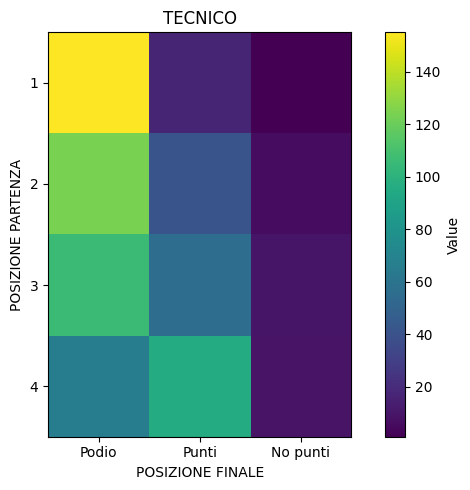

In [21]:
technical = OLAP[:,:,0]

plt.figure(figsize=(7,5))
plt.title('TECNICO')
plt.ylabel('POSIZIONE PARTENZA')
plt.yticks([0,1,2,3], ['1', '2', '3', '4'])
plt.xlabel('POSIZIONE FINALE')
plt.xticks([0,1,2], ['Podio', 'Punti', 'No punti'])
plt.imshow(technical)
plt.colorbar(label = "Value")

plt.tight_layout()
plt.show()


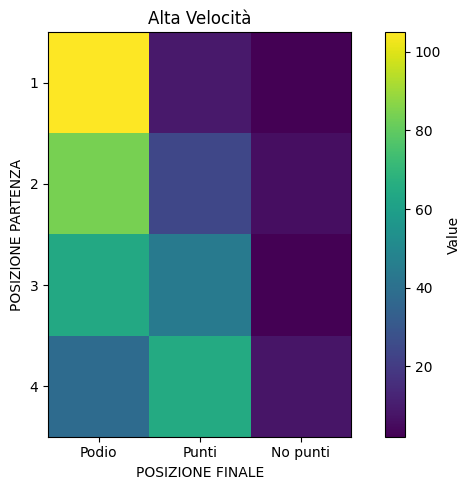

In [22]:
highspeed = OLAP[:,:,1]

plt.figure(figsize=(7,5))
plt.title('Alta Velocità')
plt.ylabel('POSIZIONE PARTENZA')
plt.yticks([0,1,2,3], ['1', '2', '3', '4'])
plt.xlabel('POSIZIONE FINALE')
plt.xticks([0,1,2], ['Podio', 'Punti', 'No punti'])
plt.imshow(highspeed)
plt.colorbar(label = "Value")

plt.tight_layout()
plt.show()


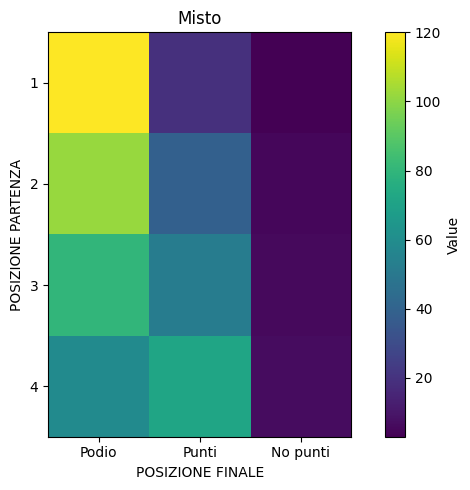

In [23]:
misto = OLAP[:,:,2]

plt.figure(figsize=(7,5))
plt.title('Misto')
plt.ylabel('POSIZIONE PARTENZA')
plt.yticks([0,1,2,3], ['1', '2', '3', '4'])
plt.xlabel('POSIZIONE FINALE')
plt.xticks([0,1,2], ['Podio', 'Punti', 'No punti'])
plt.imshow(misto)
plt.colorbar(label = "Value")

plt.tight_layout()
plt.show()

### Osservazioni 

Grazie all'analisi OLAP abbiamo emerso due rilievi principali:

1.  **Elevata Probabilità di Podio per le Prime File:** I piloti che ottengono una qualifica nelle **prime due file della griglia di partenza** (corrispondenti alle posizioni da P1 a P4) mostrano una spiccata e consistente tendenza a concludere la gara sul **podio**.

2.  **Solida Garanzia di Piazzamento a Punti:** Oltre alla forte propensione al podio, è emerso che i piloti partiti da queste posizioni di vertice riescono quasi sempre a terminare la competizione **all'interno della zona punti** (le prime dieci posizioni). 

**Implicazioni Preliminari:**
Questi risultati preliminari suggeriscono che una qualifica nelle primissime posizioni non solo massimizza le possibilità di un piazzamento di prestigio come il podio, ma offre anche una sorta di garanzia di ottenere un risultato utile ai fini della classifica. 

### Percentuali di arrivi sul podio per posizione di partenza e tipo di circuito


Calcoliamo le percentuali di arrivi sul podio per ogni categoria e per le prime due file (dal primo al quarto posto in griglia di partenza) e le visualizziamo tramite un grafico a barre e una heatmap.

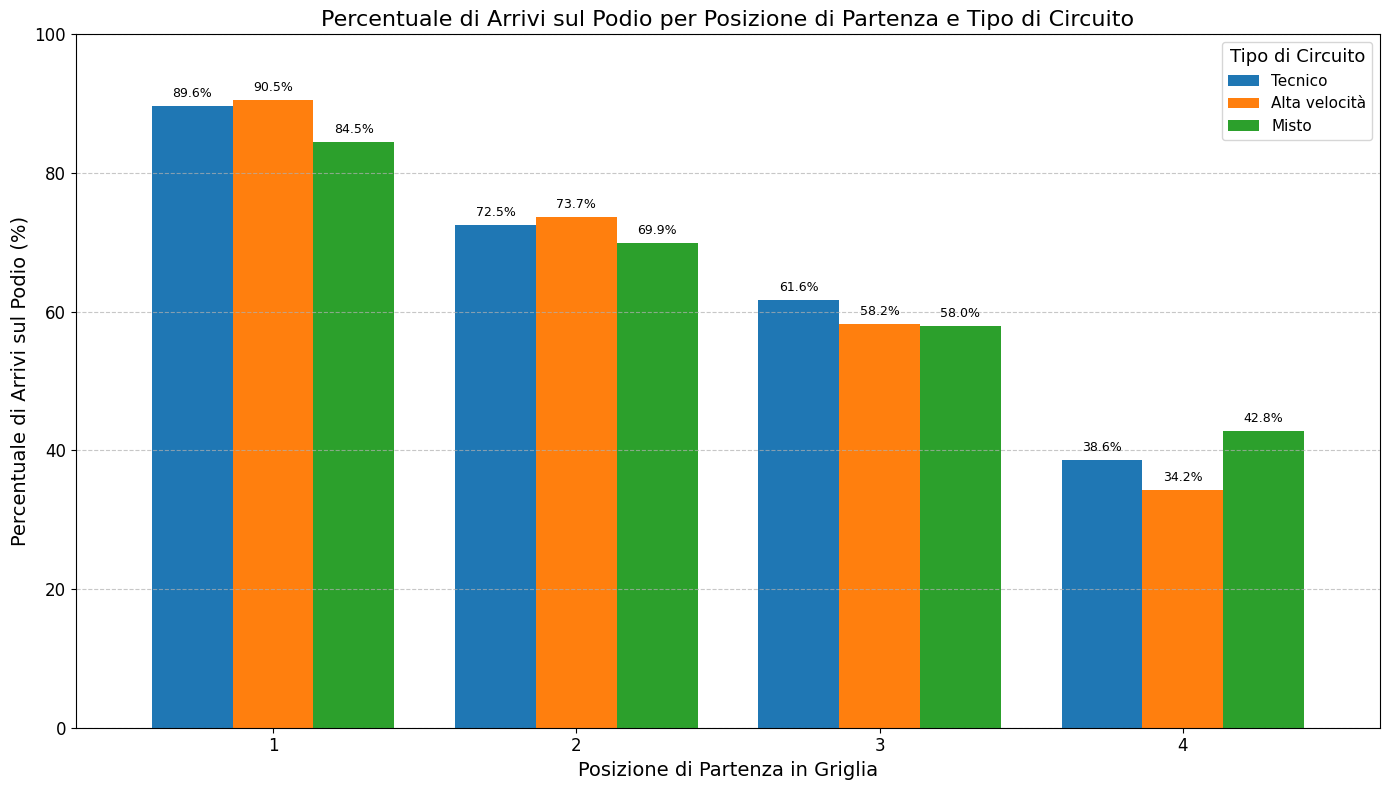

In [24]:
# Indice 0 per 'Podio' in placements
podium_counts = OLAP[:, 0, :]  

# Sommiamo i conteggi su tutti i tipi di piazzamento (Podio, Punti, No punti)
total_starts = np.sum(OLAP, axis=1) 


podium_percentages = np.divide(podium_counts, total_starts, 
                               out=np.zeros_like(podium_counts, dtype=float), 
                               where=total_starts != 0) * 100

df_podium_percentages = pd.DataFrame(podium_percentages, index=grid, columns=types)

ax = df_podium_percentages.plot(kind='bar', figsize=(14, 8), width=0.8)

plt.title('Percentuale di Arrivi sul Podio per Posizione di Partenza e Tipo di Circuito', fontsize=16)
plt.xlabel('Posizione di Partenza in Griglia', fontsize=14)
plt.ylabel('Percentuale di Arrivi sul Podio (%)', fontsize=14)
plt.xticks(rotation=0, ha='center', fontsize=12) 
plt.yticks(fontsize=12)
plt.legend(title='Tipo di Circuito', title_fontsize='13', fontsize='11')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100) 

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=9)

plt.tight_layout() 
plt.show()

Possiamo anche visualizzarli tramite una heatmap.

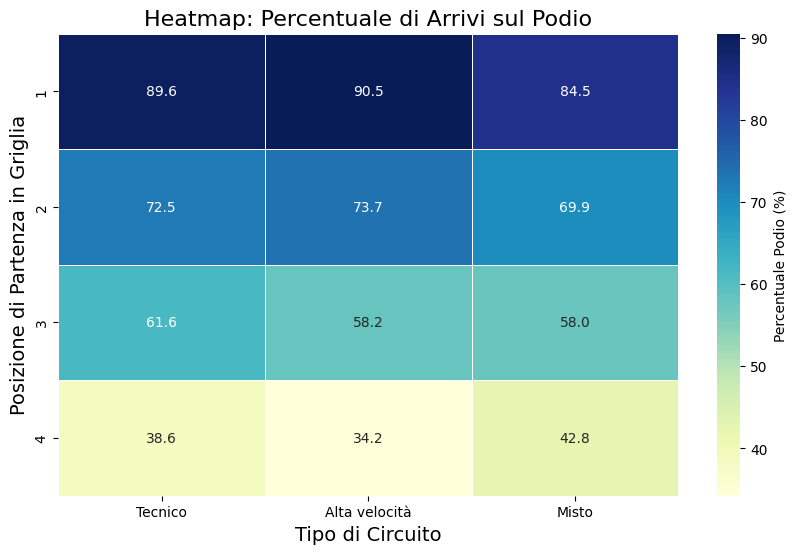

In [25]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_podium_percentages, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Percentuale Podio (%)'})
plt.title('Heatmap: Percentuale di Arrivi sul Podio', fontsize=16)
plt.xlabel('Tipo di Circuito', fontsize=14)
plt.ylabel('Posizione di Partenza in Griglia', fontsize=14)
plt.show()

### Impatto della Posizione di Partenza per Tipologia di Circuito

Analizzando la percentuale di di arrivi sul podio dei piloti che partono dalle prime due file, emergono interessanti risultati:

*   **Circuiti ad Alta Velocità:**
    L'impatto della posizione di partenza sulla probabilità di ottenere un piazzamento in top 3 sembra essere particolarmente pronunciato per i piloti che partono dalle **prime due posizioni** della griglia. Per le posizioni successive, questa influenza appare ridotta.

*   **Circuiti Tecnici e Misti:**
    In contrasto, su queste tipologie di tracciato, la posizione di partenza manifesta la sua maggiore influenza per i piloti situati al **terzo e quarto posto**. Anche qui, per le altre posizioni, l'impatto appare ridotto.


Questi risultati potrebbero suggerire che nei circuiti ad alta velocità, partire davanti (P1 o P2) potrebbe conferire un vantaggio maggiore, rendendo più agevole la difesa della posizione, potenzialmente a causa delle minori opportunità di sorpasso o della maggiore importanza della pura performance motoristica sui lunghi rettilinei.

Inoltre, in circuiti tecnici e misti, la maggiore influenza osservata per P3 e P4 (rispetto a P1/P2 in questi tracciati, o rispetto a P3/P4 nei circuiti veloci) potrebbe indicare una maggiore facilità di sorpasso e rimescolamento delle posizioni.


# Test Statistici

In questa sezione, eseguiamo una serie di test statistici per valutare se una posizione di partenza più avanzata si traduca in una posizione finale media significativamente migliore.

**Obiettivo Primario del Test:**
Per ogni coppia di posizioni di partenza nelle prime due filevogliamo verificare se chi parte davanti ottiene mediamente un piazzamento migliore.
Le ipotesi per il t-test a una coda sono definite come segue:
*   **Ipotesi Nulla (H₀):** La posizione finale media del pilota partito più avanti *non è inferiore* (cioè è uguale o peggiore) a quella del pilota partito più indietro.
*   **Ipotesi Alternativa (H₁):** La posizione finale media del pilota partito più avanti *è inferiore* (cioè migliore) rispetto a quella del pilota partito più indietro.

Utilizzeremo un **t-test ad una coda** con un **livello di significatività α = 0.05**. L'argomento `alternative='less'` nel test indica che ci aspettiamo che il primo gruppo (posizione di partenza più avanzata) abbia una media di posizione finale inferiore.

**Analisi Aggiuntiva:**
Oltre ai test di ipotesi diretti, condurremo un'analisi descrittiva per confrontare l'entità della differenza media di posizione finale *all'interno della prima fila* (P1 vs. P2) con quella *all'interno della seconda fila* (P3 vs. P4). Questo ci aiuterà a comprendere se il "salto" prestazionale tra compagni di fila sia più o meno marcato a seconda che si tratti della prima o della seconda fila.

In [26]:
# Test statistici

# Definiamo le coppie da confrontare (prime due linee)
comparison_pairs = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

def pair_position_comparison(tipo_circuito):
    print(f"\n--- Tipo Circuito: {tipo_circuito} ---")
    df_circuito = df[df['tipo_circuito'] == tipo_circuito]

    # Itera sulle coppie di posizioni di partenza da confrontare
    for p_start1, p_start2 in comparison_pairs:
        print(f"\n  Confronto: P{p_start1} vs P{p_start2}")

        group1_pos_finale = df_circuito[df_circuito['posizione_partenza'] == p_start1]['posizione_finale'].dropna()
        group2_pos_finale = df_circuito[df_circuito['posizione_partenza'] == p_start2]['posizione_finale'].dropna()

        t_stat, p_value = stats.ttest_ind(
            group1_pos_finale,
            group2_pos_finale,
            equal_var=False,      
            alternative='less',    
        )

        print(f"    Media Pos. Finale P{p_start1}: {group1_pos_finale.mean():.2f} (N={len(group1_pos_finale)})")
        print(f"    Media Pos. Finale P{p_start2}: {group2_pos_finale.mean():.2f} (N={len(group2_pos_finale)})")
        print(f"    T-statistic:              {t_stat}")
        print(f"    P-value:                  {p_value}")

        # Interpretazione del p-value
        if p_value < 0.05:
            print(f"    -> Differenza statisticamente significativa (p < 0.05).")
            print(f"       La posizione finale media per P{p_start1} è significativamente inferiore a quella per P{p_start2}.")
        else:
            print(f"    -> Differenza non statisticamente significativa (p >= 0.05).")

    medie_posizioni = {}

    # Calcoliamo le medie per ogni posizione di partenza
    for p_start in [1, 2, 3, 4]:
        pos_finale_group = df_circuito[df_circuito['posizione_partenza'] == p_start]['posizione_finale'].dropna()
        if len(pos_finale_group) > 0:
            medie_posizioni[p_start] = pos_finale_group.mean()
        else:
            medie_posizioni[p_start] = None 

    # --- Calcolo e confronto differenze tra file ---
    print(f"\n  Confronto Differenze Medie tra File (Tipo: {tipo_circuito}):")

    diff_fila1 = None
    if medie_posizioni.get(1) is not None and medie_posizioni.get(2) is not None:
        diff_fila1 = abs(medie_posizioni[1] - medie_posizioni[2])
        print(f"    Differenza Media Fila 1 (P1 vs P2): {diff_fila1:.2f} (Basata su medie {medie_posizioni[1]:.2f} e {medie_posizioni[2]:.2f})")
    else:
        print("    Differenza Media Fila 1 (P1 vs P2): Dati insufficienti.")

    diff_fila2 = None
    if medie_posizioni.get(3) is not None and medie_posizioni.get(4) is not None:
        diff_fila2 = abs(medie_posizioni[3] - medie_posizioni[4])
        print(f"    Differenza Media Fila 2 (P3 vs P4): {diff_fila2:.2f} (Basata su medie {medie_posizioni[3]:.2f} e {medie_posizioni[4]:.2f})")
    else:
        print("    Differenza Media Fila 2 (P3 vs P4): Dati insufficienti.")

    # Confronto descrittivo
    if diff_fila1 is not None and diff_fila2 is not None:
        if abs(diff_fila1 - diff_fila2) < 0.1: # Tolleranza piccola per definire "simili"
            print("    -> Le differenze medie tra le file sono molto simili.")
        elif diff_fila1 > diff_fila2:
            print("    -> La differenza media tra P1 e P2 è MAGGIORE di quella tra P3 e P4.")
        else:
            print("    -> La differenza media tra P3 e P4 è MAGGIORE di quella tra P1 e P2.")
    

### Applicazione dei Test Statistici per Tipologia di Circuito

Dopo aver definito la nostra metodologia di test, applichiamo ora la funzione `pair_position_comparison` a ciascuna delle tre tipologie di circuito identificate:
- Tecnico
- Alta Velocità
- Misto

In [27]:
pair_position_comparison("Tecnico")


--- Tipo Circuito: Tecnico ---

  Confronto: P1 vs P2
    Media Pos. Finale P1: 1.88 (N=173)
    Media Pos. Finale P2: 3.19 (N=171)
    T-statistic:              -5.144888298837578
    P-value:                  2.530304885117696e-07
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P2.

  Confronto: P1 vs P3
    Media Pos. Finale P1: 1.88 (N=173)
    Media Pos. Finale P3: 3.89 (N=172)
    T-statistic:              -7.357148145627128
    P-value:                  1.1806674107418948e-12
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P3.

  Confronto: P1 vs P4
    Media Pos. Finale P1: 1.88 (N=173)
    Media Pos. Finale P4: 4.60 (N=171)
    T-statistic:              -10.357593493471702
    P-value:                  1.0434455211769619e-21
    -> Differenza statisticamente significativa (p < 0.05).
   

#### Risultati per Circuiti Tecnici

**Verifica del Vantaggio della Posizione di Partenza:**
Sui circuiti *Tecnici*, i test confermano che partire da una posizione di vantaggio si traduce generalmente in una posizione finale media migliore e statisticamente significativa (come indicato dai p-value < 0.05 nei confronti tra posizioni).

**Analisi delle Medie tra Compagni di Fila:**
Confrontando l'entità delle differenze medie di posizione finale tra i compagni di fila:
- La differenza media osservata tra chi parte in P1 e P2 è di **1.31**.
- La differenza media osservata tra chi parte in P3 e P4 è di **0.71**.

Per i circuiti tecnici, si nota che la differenza media di piazzamento tra il primo e il secondo pilota (P1 vs. P2) è **notevolmente maggiore** rispetto alla differenza registrata tra il terzo e il quarto pilota (P3 vs. P4). Questo suggerisce che, su questi tracciati, c'è più differenza tra P1 e P2 rispetto tra P3 e P4.

Adesso analizziamo la categoria "Alta velocità"

In [28]:
pair_position_comparison("Alta velocità")


--- Tipo Circuito: Alta velocità ---

  Confronto: P1 vs P2
    Media Pos. Finale P1: 2.02 (N=116)
    Media Pos. Finale P2: 3.33 (N=114)
    T-statistic:              -3.5427350886123063
    P-value:                  0.0002522749480888565
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P2.

  Confronto: P1 vs P3
    Media Pos. Finale P1: 2.02 (N=116)
    Media Pos. Finale P3: 3.87 (N=110)
    T-statistic:              -6.186830755573988
    P-value:                  1.6005731181035518e-09
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P3.

  Confronto: P1 vs P4
    Media Pos. Finale P1: 2.02 (N=116)
    Media Pos. Finale P4: 5.10 (N=111)
    T-statistic:              -8.349244938191639
    P-value:                  9.745420078712253e-15
    -> Differenza statisticamente significativa (p < 0.05)

#### Risultati per Circuiti ad Alta Velocità

Analogamente, sui circuiti ad *Alta Velocità*, i test indicano che una posizione di partenza più avanzata è generalmente associata a una posizione finale media migliore, con significatività statistica nei casi rilevanti.

**Analisi Comparativa delle Differenze Medie tra Compagni di Fila:**
Riguardo al confronto delle differenze medie di posizione finale:
- La differenza media osservata tra chi parte in P1 e P2 è di **1.32**.
- La differenza media osservata tra chi parte in P3 e P4 è di **1.23**.

Su questa tipologia di circuito, le differenze medie di piazzamento tra P1-P2 e P3-P4 appaiono **molto simili**. Ciò potrebbe indicare che, sui circuiti veloci, l'impatto relativo di essere una posizione avanti o indietro all'interno della stessa fila (considerando le prime due) è comparabile.

In [29]:
pair_position_comparison("Misto")


--- Tipo Circuito: Misto ---

  Confronto: P1 vs P2
    Media Pos. Finale P1: 2.32 (N=142)
    Media Pos. Finale P2: 3.32 (N=146)
    T-statistic:              -3.0537962860193963
    P-value:                  0.0012410918872623614
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P2.

  Confronto: P1 vs P3
    Media Pos. Finale P1: 2.32 (N=142)
    Media Pos. Finale P3: 4.12 (N=138)
    T-statistic:              -5.290963278001208
    P-value:                  1.3128468126276763e-07
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P3.

  Confronto: P1 vs P4
    Media Pos. Finale P1: 2.32 (N=142)
    Media Pos. Finale P4: 4.70 (N=138)
    T-statistic:              -6.838753555061969
    P-value:                  3.048486544534256e-11
    -> Differenza statisticamente significativa (p < 0.05).
      

#### Risultati per Circuiti Misti

**Verifica del Vantaggio della Posizione di Partenza:**
Anche per i circuiti *Misti*, si conferma la tendenza generale: una posizione di partenza migliore è correlata a una posizione finale media inferiore (migliore), supportata da significatività statistica dove applicabile.

**Analisi Comparativa delle Differenze Medie tra Compagni di Fila:**
Analizzando le differenze medie di posizione finale:
- La differenza media osservata tra chi parte in P1 e P2 è di **1.00** posizione.
- La differenza media osservata tra chi parte in P3 e P4 è di **0.58** posizioni.

Sui circuiti misti, la differenza di prestazione media tra chi si qualifica primo e secondo (P1 vs. P2) è **maggiore** rispetto alla differenza tra chi si qualifica terzo e quarto (P3 vs. P4). Questo implica che, su tracciati con caratteristiche bilanciate, il vantaggio specifico di conquistare la pole position rispetto alla seconda piazza è particolarmente pronunciato, più di quanto non lo sia il vantaggio della terza posizione sulla quarta.

# Regressione Logistica

Vogliamo creare un modello predittivo con l'algoritmo di **regressione logistica** che data la posizione di partenza, il tipo di circuito e la forma fisica del pilota, possa prevedere se un pilota arrivi sul podio.

Per farlo, dobbiamo creare un dataframe che abbia: posizione di partenza, posizione in classifica del pilota pre-gara, tipo di circuito e posizione finale (Podio/No Podio).

Per creare il dataframe dobbiamo:

1. Prendere i dati da tutti i file csv
2. Creare un dataframe con le colonne sopra elencate
3. Creare una colonna `Podio` che contiene 1 se il pilota è arrivato sul podio e 0 altrimenti
4. Creare una colonna `Tipo Circuito` che contiene il tipo di circuito
    - Dividiamo il tipo di circuito in tre categorie: Alta Velocità, Tecnico e Misto per evitare che il modello impari un falso ordine tra le categorie, utilizzando il metodo one-hot encoding
5. Creare una colonna `Posizione di Partenza` che contiene la posizione di partenza
6. Creare una colonna `Posizione in Classifica` che contiene la posizione in classifica del pilota pre-gara

Per forma fisica intendiamo la posizione in classifica del pilota pre-gara. Solitamente la posizione in classifica rispecchia la qualità delle performance stagionali, la concentrazione del pilota e la prestazione della macchina.

In [30]:
# Uniamo races e circuits per ottenere il tipo di circuito per ogni gara
driver_standings = driver_standings[driver_standings['year'] >= 2000]
races_circuits = pd.merge(
                    races, 
                    circuits[['circuitId', 'circuitType']], 
                    on='circuitId', 
                    how='left', 
                    validate='m:m'
                )

# Uniamo standings con races per avere anno e round della classifica
driver_standings_info = pd.merge(
                            driver_standings[['raceId', 'driverId', 'points', 'positionDisplayOrder']],
                            races[['raceId', 'year', 'round']],
                            on='raceId', 
                            how='left', 
                            validate='m:m')

driver_standings_info = driver_standings_info.rename(columns={'positionDisplayOrder': 'classifica_post_gara'})

driver_standings_info['round_per_merge'] = driver_standings_info['round'] + 1
standings_per_merge = driver_standings_info[[
    'driverId', 'year', 'round_per_merge', 'classifica_post_gara'
]]


results_with_race_info = pd.merge(results[['raceId', 'driverId', 'constructorId', 'gridPositionNumber', 'positionNumber', 'points', 'laps']],
                                  races_circuits[['raceId', 'year', 'round', 'circuitType_y']],
                                  on='raceId', how='left', validate='m:1')

# Uniamo i risultati con le Classifiche pre-gara
final_df = pd.merge(
    results_with_race_info,
    standings_per_merge,
    left_on=['driverId', 'year', 'round'],
    right_on=['driverId', 'year', 'round_per_merge'],
    how='left',
    validate='m:m'
)

final_df = final_df.rename(columns={'classifica_post_gara': 'classifica_pre_gara'})

f1_analysis_df = final_df[final_df['round'] != 1].copy()
f1_analysis_df['podio'] = f1_analysis_df['positionNumber'].apply(lambda x: 1 if x < 4 else 0)

f1_analysis_df = f1_analysis_df[['gridPositionNumber', 'classifica_pre_gara', 'circuitType_y', 'podio']]
f1_analysis_df = f1_analysis_df.rename(columns={
    'gridPositionNumber': 'posizione_partenza',
    'classifica_pre_gara': 'classifica_pre_gara_rank',
    'circuitType_y': 'tipo_circuito',
})

f1_analysis_df = f1_analysis_df.dropna(subset=['posizione_partenza', 'podio', 'classifica_pre_gara_rank'])


f1_analysis_df['posizione_partenza'] = f1_analysis_df['posizione_partenza'].astype(int)
f1_analysis_df['classifica_pre_gara_rank'] = f1_analysis_df['classifica_pre_gara_rank'].astype(int)

# Codifichiamo 'tipo_circuito' 
f1_analysis_df['alta_velocità'] = f1_analysis_df['tipo_circuito'].apply(lambda x: 1 if x == 'Alta velocità' else 0)
f1_analysis_df['tecnico'] = f1_analysis_df['tipo_circuito'].apply(lambda x: 1 if x == 'Tecnico' else 0)
f1_analysis_df['misto'] = f1_analysis_df['tipo_circuito'].apply(lambda x: 1 if x == 'Misto' else 0)

f1_analysis_df = f1_analysis_df.drop(columns=['tipo_circuito'])

# Visualizziamo il dataframe
f1_analysis_df.head()


,posizione_partenza,classifica_pre_gara_rank,podio,alta_velocità,tecnico,misto
22,3,1,1,0,0,1
23,5,5,1,0,0,1
26,11,3,0,0,0,1
30,8,6,0,0,0,1
33,18,8,0,0,0,1


### Allenamento del modello
Ora che abbiamo creato il dataframe necessario per il modello di regressione lineare, dividiamo i dati in training e validation set utilizzando la funzione `train_test_split`.

In [31]:
feature = ["posizione_partenza", "classifica_pre_gara_rank", "alta_velocità", "tecnico", "misto"]

# I dati in input sono posizione di partenza, tempo del primo giro e tipo di circuito
X = f1_analysis_df[feature]

# I dati in output sono la posizione finale
y = f1_analysis_df["podio"]

# Facciamo il train test split usando il 20% come test set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

Adesso che abbiamo preparato i dati dividendo il dataset in train e validation set, possiamo allenare il modello.

In [32]:
model = LogisticRegression(random_state=42)

# Alleniamo sul dataset di training
model.fit(X_train, y_train)

# Facciamo le predizioni
y_pred = model.predict(X_valid)

### Correttezza
Verfichiamo adesso la correttezza del modello confrontando il nostro modello con il modello null

------Modello Logistic Regression------
Accuracy: 0.8973655323819978
Precision: 0.6032388663967612
Recall: 0.6260504201680672
F1-Score: 0.6144329896907217


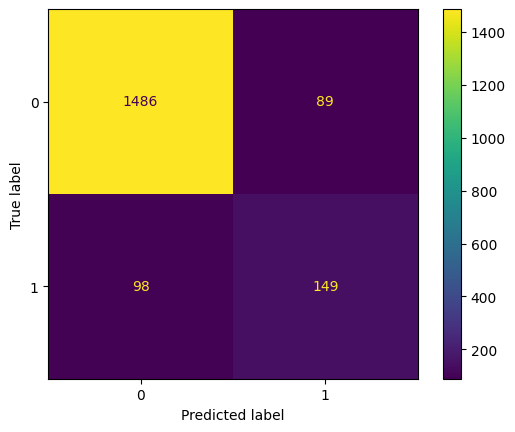

In [33]:
print("------Modello Logistic Regression------")
print("Accuracy:",metrics.accuracy_score(y_pred,y_valid))
print("Precision:",metrics.precision_score(y_pred,y_valid))
print("Recall:",metrics.recall_score(y_pred,y_valid))
print("F1-Score:",metrics.f1_score(y_pred,y_valid))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(y_valid, y_pred), display_labels = [0, 1])
cm_display.plot()

In [34]:
null_model_y = np.full(len(y_valid), 0)

print("------Null Model------")
print("Accuracy:",metrics.accuracy_score(null_model_y,y_valid))

------Null Model------
Accuracy: 0.8644346871569704


### Valutazione delle Performance del Modello Principale

Analizzando le metriche del nostro modello di regressione logistica (addestrato su dati dal 2000 in poi), osserviamo quanto segue:

*   **Accuracy vs. Modello Nullo:**
    L'accuracy del nostro modello, pari a 90% è superiore a quella del modello nullo (che predice sempre la classe maggioritaria, no podio in questo caso, e raggiunge un'accuracy di 86%). Questo incremento indica che il nostro modello è più preciso.

*   **Precision:**
    Il modello raggiunge una precisione del **60%**. Questo significa che **quando il modello predice che un pilota otterrà un risultato "positivo" (finirà sul podio), ha ragione nel 60% dei casi.** La formula è TP / (TP + FP).

*   **Recall (Sensitività):**
    Il recall è del **63%**. Ciò indica che **il modello identifica correttamente il 63% di tutti i piloti che effettivamente hanno ottenuto un risultato "positivo".** La formula è TP / (TP + FN).

*   **Considerazioni su Precision e Recall:**
    Questi valori suggeriscono un bilanciamento tra la capacità del modello di non etichettare erroneamente un caso come positivo (Precision) e la sua abilità nel trovare tutti i casi positivi (Recall). 
    L'F1-Score, che bilancia Precision e Recall, è di 61%, fornendo una misura aggregata della performance.

### Impatto del Filtraggio Temporale dei Dati

Per valutare l'efficacia della nostra scelta di utilizzare i dati delle gare a partire dall'anno 2000, abbiamo addestrato un modello di regressione logistica alternativo sull'intero dataset storico disponibile, senza applicare alcun filtro temporale. Di seguito sono riportate le sue performance:

**Metriche del Modello su Dati Non Filtrati (Pre-2000 Inclusi):**

*   **Accuracy:** 0.866 (86.6%)
    *   *(Percentuale di predizioni corrette sul totale).*
*   **Precision:** 0.459 (45.9%)
    *   *(Dei piloti predetti come "positivi", quanti lo erano effettivamente. TP / (TP + FP)).*
*   **Recall:** 0.639 (63.9%)
    *   *(Dei piloti che erano effettivamente "positivi", quanti sono stati identificati correttamente. TP / (TP + FN)).*

*   **Confusion Matrix:**
    ```
              Predetto Negativo   Predetto Positivo
    Attuale Negativo      2657 (TN)         146 (FP)
    Attuale Positivo       304 (FN)         258 (TP)
    ```
    *   TN (True Negatives): 2657
    *   FP (False Positives): 146
    *   FN (False Negatives): 304
    *   TP (True Positives): 258

**Osservazioni e Confronto:**

Confrontando queste metriche con quelle del nostro modello principale (addestrato su dati dal 2000 in poi - *si assume che queste siano state presentate prima*), osserviamo quanto segue:

*   L'**Accuracy** complessiva (0.866) su questo modello non filtrato è inferiore a quella del modello principale (che era 0.897).
*   La **Precision** (0.459) è notevolmente più bassa rispetto al modello principale (che era 0.603). Ciò indica che il modello allenato su tutti i dati storici tende a fare più errori nel classificare un pilota come "positivo" quando in realtà non lo è.
*   Il **Recall** (0.639) è comparabile rispetto al modello principale (che era 0.626).

La diminuzione della Precision e dell'Accuracy suggerisce che l'inclusione di dati molto datati introduce pattern che non sono più rappresentativi delle dinamiche attuali della Formula 1. Questo può essere dovuto per vari fattori:
- Dati molto datati potrebbero non essere precisi o addirittura sbagliati
- Cambiamenti significativi nei regolamenti tecnici, nella tecnologia delle vetture, nei circuiti e persino negli stili di guida nel corso di molti decenni possono rendere i dati più vecchi "rumorosi" o fuorvianti per un modello che cerca di predire i risultati delle gare più recenti
- Agli albori della formula 1 c'era molta più disparità tra carrozzerie, rendendo molto più semplice ottenere una posizione migliore per i piloti dei team più prestigiosi

## Testing

## Test del Modello di Predizione

Per valutare l'efficacia del nostro modello, lo testeremo su tre gare distinte, rappresentative di diverse tipologie di circuito.

Abbiamo preparato tre file csv, ciascuno contenente le informazioni di input per il modello, sia i risultati effettivi della gara, utilizzati per confrontare e validare le predizioni. Le colonne incluse in questi file sono:

*   `posizione_partenza`: La posizione di partenza del pilota.
*   `classifica_pre_gara_rank`: La posizione del pilota nella classifica generale del campionato prima della gara in esame.
*   `tipo_circuito`: Una categorizzazione del circuito (es. Tecnico, Alta Velocità, Misto).
*   `posizione_finale`: La posizione finale effettiva del pilota nella gara.
*   `nome`: Il nome del pilota.

Per ottimizzare il codice ed evitare ripetizioni, definiremo una funzione principale per l'esecuzione dei test. Inoltre, implementeremo una funzione di utilità che permette di evidenziare i falsi positivi e i falsi negativi.

In [35]:
def test_circuiti(df):
    test_prediction = df.drop(columns=['posizione_finale', 'nome'])
    prediction = model.predict(test_prediction)
    df['podio'] = prediction
    df['podio'] = df['podio'].apply(lambda x: 'Si' if x == 1 else 'No')
    df.drop(columns=['alta_velocità', 'tecnico', 'misto'], inplace=True)

    return df

def righe_da_evidenziare(df):
    numeric_posizione_finale = pd.to_numeric(df['posizione_finale'], errors='coerce')
    rows_to_highlight = df[((numeric_posizione_finale > 3) & (df['podio'] == "Si")) | ((numeric_posizione_finale < 4) & (df['podio'] == "No"))].index
    return rows_to_highlight
    

### Test circuito misto

In [36]:
test_misto = pd.read_csv("f1db-csv/test_misto.csv")

test_circuiti(test_misto)
rows_to_highlight = righe_da_evidenziare(test_misto)
test_misto.style.map(lambda _: 'background-color: darkred', subset=pd.IndexSlice[rows_to_highlight, :])


,posizione_partenza,classifica_pre_gara_rank,posizione_finale,nome,podio
0,1,3,4,Verstappen,Si
1,2,2,2,Norris,Si
2,3,6,6,Antonelli,No
3,4,1,1,Piastri,Si
4,5,7,3,Russell,No
5,6,16,9,Sainz,No
6,7,8,5,Albon,No
7,8,5,7,Leclerc,No
8,9,9,12,Ocon,No
9,10,11,10,Tsunoda,No


### Test circuito Alta velocità

In [37]:
test_alta_velocità = pd.read_csv("f1db-csv/test-alta-velocità.csv")

test_circuiti(test_alta_velocità)
rows_to_highlight = righe_da_evidenziare(test_alta_velocità)
test_alta_velocità.style.map(lambda _: 'background-color: darkred', subset=pd.IndexSlice[rows_to_highlight, :])

,posizione_partenza,classifica_pre_gara_rank,posizione_finale,nome,podio
0,1,3,2,Verstappen,Si
1,2,2,1,Piastri,Si
2,3,6,5,Russell,No
3,4,5,3,Leclerc,No
4,5,6,6,Antonelli,No
5,6,16,8,Sainz,No
6,7,7,7,Hamilton,No
7,8,15,\N,Tsunoda,No
8,9,11,\N,Gasly,No
9,10,1,4,Norris,No


### Test circuito Tecnico

In [38]:
test_tecnico = pd.read_csv("f1db-csv/test-tecnico.csv")

test_circuiti(test_tecnico)
rows_to_highlight = righe_da_evidenziare(test_tecnico)
test_tecnico.style.map(lambda _: 'background-color: red', subset=pd.IndexSlice[rows_to_highlight, :])

,posizione_partenza,classifica_pre_gara_rank,posizione_finale,nome,podio
0,1,2,1,Verstappen,Si
1,2,1,2,Norris,Si
2,3,3,3,Piastri,Si
3,4,6,4,Leclerc,No
4,5,4,5,Russell,No
5,6,5,6,Antonelli,No
6,7,13,8,Hadjar,No
7,8,8,7,Hamilton,No
8,9,7,9,Albon,No
9,10,12,10,Bearman,No


# Conclusioni

L'obiettivo di questa analisi era valutare la capacità di un modello di regressione logistica nel predire la posizione finale in gara dei piloti, considerando la tipologia di circuito e altri fattori. Il modello è stato testato su tre gare rappresentative, fornendo i seguenti risultati preliminari:

*   **Circuito Misto:**
    *   **Esito del Test:** 2 True Positive (TP), 1 False Positive (FP), 1 False Negative (FN).
    *   *(Gli altri casi sono stati correttamente classificati come True Negative (TN)).*
*   **Circuito ad Alta Velocità:**
    *   **Esito del Test:** 2 TP, 1 FN.
    *   *(Gli altri casi sono stati TN).*
*   **Circuito Tecnico:**
    *   **Esito del Test:** 3 TP.
    *   *(Nessun FP o FN osservato per i casi positivi in questo test; gli altri casi sono stati TN).*

**Valutazione Preliminare e Limiti:**

I risultati iniziali suggeriscono che il modello possiede una certa capacità predittiva, con una performance particolarmente incoraggiante sui circuiti di tipo tecnico nel nostro limitato set di test.

Tuttavia, è importante sottolineare che **la validità di queste osservazioni è significativamente limitata dal fatto che lo abbiamo testato solamente su 3 gare**. Questo non permette di trarre conclusioni definitive sulla generalizzabilità e robustezza del modello. Per confermare con maggiore certezza la "precisione" osservata, sarebbe opportuno ampliare il dataset di test con più gare.

**Riflessioni:**

Per migliorare ulteriormente l'analisi e l'affidabilità del modello si dovrebbero integrare maggiori dati importanti come le condizioni atmosferiche, che purtroppo non erano disponibili nel dataset utilizzato. 